In [1]:
import sys
import os
import jieba
import config # 自定义配置文件
import numpy as np
import pandas as pd

# 不显示VisibleDeprecation警告
import warnings
warnings.filterwarnings("ignore", category=Warning)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# 绘图显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

### 导入数据

In [2]:
data = pd.read_excel(config.WordData_path + "Participle-Jieba.xlsx")

In [14]:
hw_data = pd.read_excel(config.WordData_path + "Participle-FoolNLTK-HW.xlsx")

### 生成词向量

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer # tfidf
# 模型、数据文件保存
# from sklearn.externals import joblib
import joblib
from sklearn.datasets import load_boston
import pickle

#### 生成词汇列表

In [4]:
tokens = [] # 用于存储分词结果
for token in data["token"]:
    words = token[2:-2].split("', '")
    tokens.append(words)

In [15]:
HW_tokens = [] # 用于存储分词结果
for HW_token in hw_data["token"]:
    HW_words = HW_token[2:-2].split("', '")
    HW_tokens.append(HW_words)

In [5]:
from gensim.models import Word2Vec

#### 构建Word2Vec模型

CBOW和Skip-Gram算法的本质区别就在于输入输出选取的不同（这两种算法完全相反）
CBOW是输入上下文、输出目标词；Skip-Gram则相反

Continuous Bag of Words Model (CBOW)算法：如上所述，CBOW算法使用上下文窗口内词向量作为输入，将这些向量求和（或取均值）后，求得与输出词空间的相关性分布，进而使用softmax函数得到在整个输出词空间上的命中概率，与目标词one-hot编码的交叉熵即为loss值，通过loss针对输入和输出词向量的梯度，即可使用梯度下降（gradient descent）法得到一次针对输入和输出词向量的迭代调整。

Skip-Gram算法：使用目标词向量作为输入，求得其与输出词空间的相关性分布，进而使用softmax函数得到在整个输出词空间上的命中概率，与one-hot编码的上下文词逐一计算交叉熵，求和后即为loss值，通过loss针对输入和输出词向量的梯度，即可使用梯度下降（gradient descent）法得到一次针对输入和输出词向量的迭代调整。

In [6]:
model = Word2Vec(
    tokens,# 训练文本列表
    sg=1, # sg=1 是 skip-gram（跳字模型）算法，对低频词敏感；默认 sg=0 为 CBOW （连续词袋模型）算法。
    min_count=3, # 最小词频
    window=3, # 窗口大小，句子中当前词与目标词之间的最大距离
                )

In [16]:
HW_model = Word2Vec(
    HW_tokens,# 训练文本列表
    sg=1, # sg=1 是 skip-gram（跳字模型）算法，对低频词敏感；默认 sg=0 为 CBOW （连续词袋模型）算法。
    min_count=1, # 最小词频
    window=3, # 窗口大小，句子中当前词与目标词之间的最大距离
                )

In [17]:
model.save(config.Model_path + './W2VModel')   #model保存
HW_model.save(config.Model_path + './W2V_HW_Model')   #model保存

In [9]:
WVModel = Word2Vec.load(config.Model_path + './W2VModel')   #加载model
HW_model = Word2Vec.load(config.Model_path + './W2V_HW_Model')

In [18]:
# 增量训练word2vec
WVModel.build_vocab(HW_tokens, update=True) 
WVModel.train(HW_tokens, total_examples=WVModel.corpus_count, epochs=10)

(3046166, 3530030)

#### 效果测试

In [10]:
WVModel.wv.most_similar('双子座',topn=20)

[('天秤座', 0.9150410890579224),
 ('水瓶座', 0.9092998504638672),
 ('狮子座', 0.8967111110687256),
 ('白羊座', 0.8898422718048096),
 ('配_*_双子座', 0.8890807032585144),
 ('天蝎座', 0.8827896118164062),
 ('摩羯座', 0.8771555423736572),
 ('处女座', 0.873154878616333),
 ('配_*_白羊座', 0.8720099925994873),
 ('配_*_水瓶座', 0.8662377595901489),
 ('双鱼座', 0.8647885322570801),
 ('配_*_射手座', 0.8645358681678772),
 ('配_*_处女座', 0.8644731044769287),
 ('配_*_天蝎座', 0.862329363822937),
 ('配_*_摩羯座', 0.862004280090332),
 ('金牛座', 0.8613165020942688),
 ('天秤', 0.8612433075904846),
 ('座_*_最配', 0.8568140268325806),
 ('射手座', 0.8562303781509399),
 ('双子座_*_天秤座', 0.8531808257102966)]

In [11]:
WVModel.similarity("男生","女生") # 计算2个词之间的余弦相似度

0.8774669

In [12]:
model.wv["男生"]

array([ 0.05496832,  0.46228665, -0.07745494,  0.12258862, -0.74127793,
       -0.42457923,  0.3018039 ,  0.3464331 , -0.6888764 ,  0.06905185,
       -0.38124573, -0.536163  , -0.31578743, -0.6776546 , -0.16001803,
        0.06339368, -0.61868757, -1.0003515 , -0.26520336,  0.00992338,
       -0.04238028,  0.5551354 ,  0.40921125,  0.98153365, -0.12359579,
       -0.984059  ,  0.46443188, -0.29287806, -0.19590102,  0.63780487,
        0.5337222 ,  0.06775039,  1.166235  ,  0.80363744,  1.9223127 ,
        0.30942756, -1.1091926 ,  0.52006745,  0.47541708,  0.48189452,
       -0.79189295,  0.13062844, -0.18568112,  2.0722032 ,  0.07922024,
       -0.7548234 ,  0.17938787,  0.6796631 , -1.0768248 , -0.12920764,
        0.46464205,  0.65288544, -0.94456464,  1.0677023 , -0.23670615,
        0.54689384, -0.19425319,  0.39938185, -0.9938196 ,  0.8136649 ,
        0.4458264 , -0.16994844,  0.21095097, -0.47236323, -0.25758877,
        0.4221231 ,  0.70996135, -1.071909  ,  0.03211325, -1.10

In [13]:
vectors  = WVModel.wv.vectors

In [9]:
vectors.shape

(457670, 100)

In [18]:
# 预测与'男生'和'女生'最相似，而与星座不接近的词
WVModel.most_similar(positive=['男生','女生'], negative=['星座'])

[('头像_*_女生', 0.632808268070221),
 ('女生_*_适合', 0.5756181478500366),
 ('qq_*_头像', 0.5693835020065308),
 ('男生_*_头像', 0.5672847032546997),
 ('女生_*_图片', 0.5564982891082764),
 ('情侣', 0.553435206413269),
 ('欧美', 0.5516586303710938),
 ('头像_*_qq', 0.5468611717224121),
 ('气质', 0.545574426651001),
 ('情侣_*_头像', 0.5423386096954346)]

In [19]:
rawWV = []
word2ind = {}
for i ,w in enumerate(WVModel.wv.index2entity):
    rawWV.append(WVModel.wv[w]) # 词向量
    word2ind[w] = i # {词语:序号}

In [20]:
rawWV = np.array(rawWV)

In [21]:
from sklearn.decomposition import PCA
PCA_rawWV = PCA(n_components=2).fit_transform(rawWV)

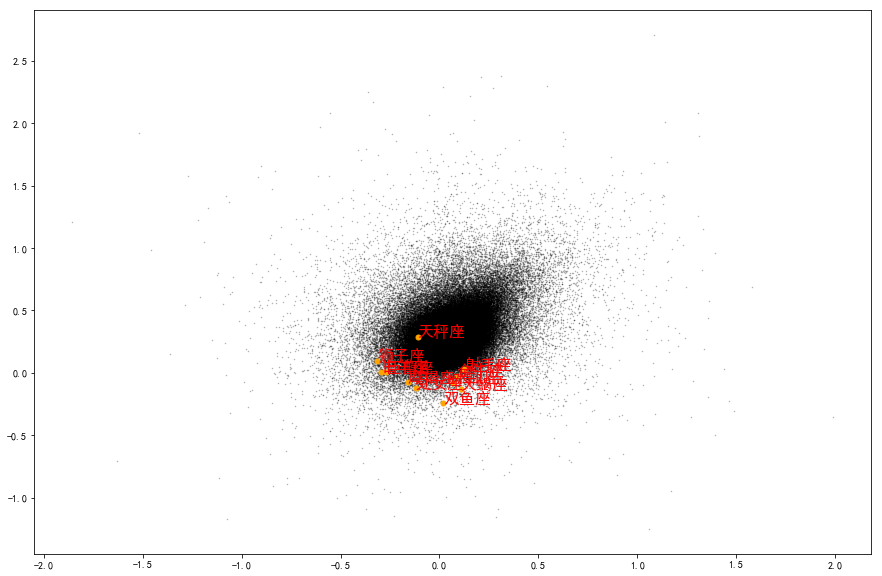

In [22]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()
ax.set_facecolor('white') # 背景色
ax.plot(rawWV[:, 0],rawWV[:, 1],'.',markersize=1,alpha=0.3,color='black')

# 绘制特俗单词的向量
words = ["天秤座","水瓶座",'摩羯座','天蝎座','双鱼座','白羊座','狮子座','巨蟹座','射手座','处女座','金牛座']
Font = matplotlib.font_manager.FontProperties(fname=r"C:\\Windows\\Fonts\\simhei.ttf",size=16)
for word in words:
    if word in word2ind:
        ind = word2ind[word]
        xy = rawWV[ind]
        plt.plot(xy[0],xy[1],'.',alpha=1,color='orange',markersize=10)
        plt.text(xy[0],xy[1],word,fontproperties=Font,alpha=1,color='red')

#### 生成词向量

In [19]:
def getVector_v2(cutWords, word2vec_model):
    vector_list = [ word2vec_model[k] for k in cutWords if k in word2vec_model]
    vector_df = pd.DataFrame(vector_list)
    cutWord_vector = vector_df.mean(axis=0).values
    return cutWord_vector

In [20]:
vector_list = []
for words in tokens:
    vector_list.append(getVector_v2(words, WVModel))
X_sp = np.array(vector_list)

In [21]:
X_sp.shape

(17651, 100)

In [26]:
HW_vector_list = []
for words in HW_tokens:
    HW_vector_list.append(getVector_v2(words, HW_model))
HW_sp = np.array(HW_vector_list)

In [27]:
HW_sp.shape

(17651, 100)

#### 词向量持久化

In [29]:
# 导入自定义模块
sys.path.append(config.Py_path) # 添加路径
from SaveAndLoad import save_pkl # 数据文件持久化

In [31]:
# 存储词向量数据
save_pkl(X_sp,"W2V_X_sp")
save_pkl(HW_sp,"W2V_HW_sp")

持久化存储路径：./data/WordVectorData/W2V_X_sp.feat
持久化存储路径：./data/WordVectorData/W2V_HW_sp.feat
